In [1]:
import sys
import os

# Get the absolute path to the repo root (parent of both src and notebook folders)
repo_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
# Add the repo root to the Python path
sys.path.append(repo_root)

# Now you can import from src
from src.master.data import load_and_crop_data
from src.master.visualize import visualize_masks
from src.master.evaluate import evaluate_binary_masks
from src.master.model import (
    RandomForestClassifier, KNNClassifier, LogRegClassifier, SVMClassifier,
    CLIPEmbedding, HoGEmbedding, ResNET18Embedding
)

In [2]:
from src.master.data import KFoldSegmentationManager

# Define the dataset path
dataset_path = "C:/Users/gtoft/OneDrive/DTU/4_Semester_AS/Master_Thesis/data/sam_inference/processed_data/meatballs"

# Create dataset manager for this specific dataset
dataset_manager = KFoldSegmentationManager(
    dataset_path=dataset_path,
    class_id=1
)

# Print dataset information
print(f"Dataset info: {dataset_manager.get_dataset_info()}")

# Get 5-fold cross validation dataloaders
folds = dataset_manager.get_kfold_dataloaders(k=5, batch_size=1)

# Example: Using with your embedding-classifier framework
print("\nTraining example with first fold:")
train_loader, val_loader = folds[0]

# Get training data directly in the format for classifier.fit()
train_images, train_masks, train_labels = dataset_manager.get_training_data(train_loader)

print(f"Training data prepared:")
print(f"  Images: {len(train_images)}")
print(f"  Shape: {train_images[0].shape}")
print(f"  GT masks: {len(train_masks)}")
print(f"  Shape: {train_masks[0][0].shape}")
print(f"  Labels: {len(train_labels)}")
print(f"  Sample: {train_labels[0]}")


Dataset info: {'dataset_name': 'meatballs', 'class_id': 1, 'total_samples': 200}

Training example with first fold:
Training data prepared:
  Images: 40
  Shape: (270, 250, 3)
  GT masks: 40
  Shape: (270, 250)
  Labels: 40
  Sample: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


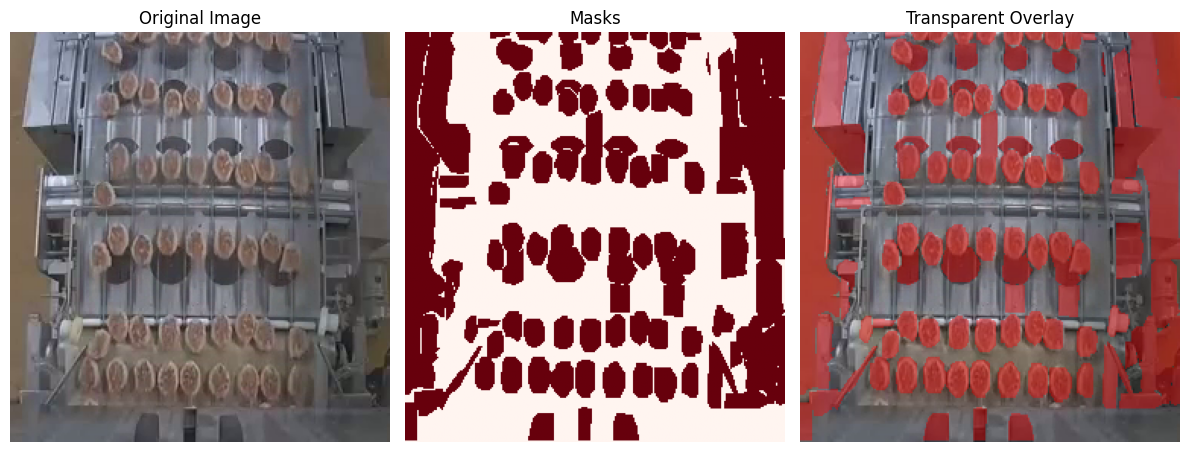

In [3]:
visualize_masks(train_images[0], train_masks[0])

In [4]:
# 1. Create embedding and classifier
config = {
    'clip_model': 'ViT-B/32',
    'use_PCA': True,
    'PCA_var': 0.95
}
embedding = ResNET18Embedding(config)
classifier = RandomForestClassifier(config, embedding)



Using device: cuda


c:\Users\gtoft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\gtoft\miniconda3\envs\masterenv\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
# 2. Train classifier directly with the data
classifier.fit(train_images, train_masks, train_labels)

Reduced feature dimension from 896 to 139 with 95.0% variance preserved


True

(270, 250, 3)
270


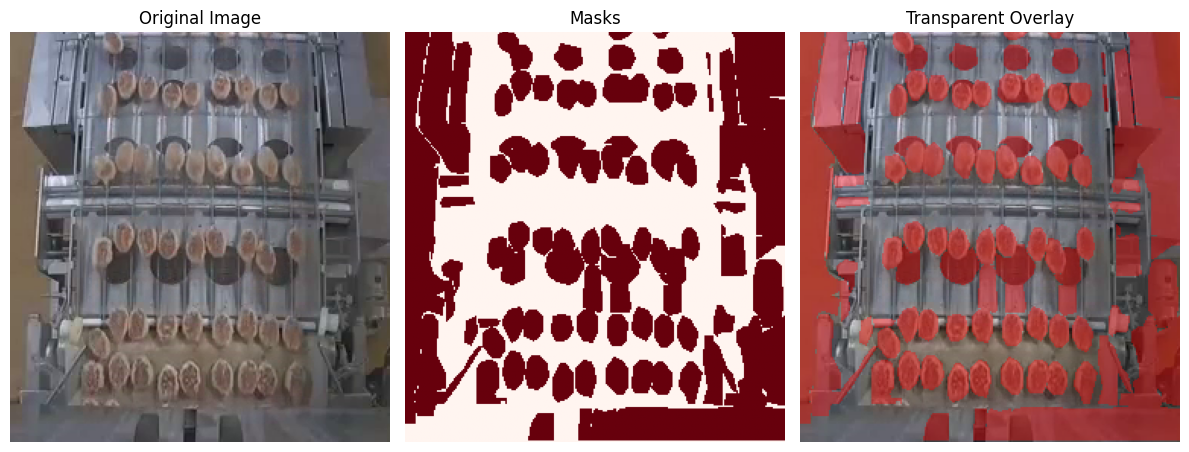

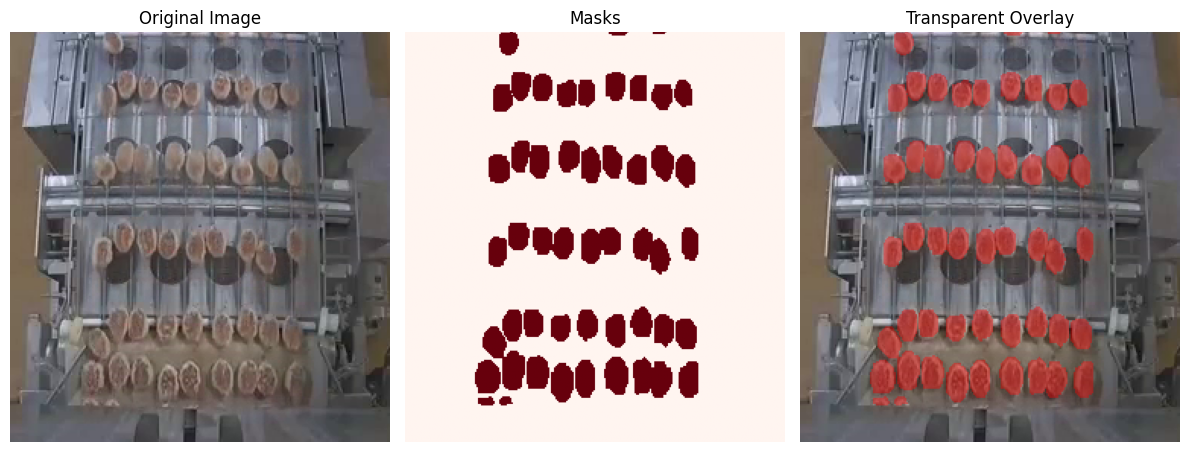

In [6]:
# 3. Get validation data for prediction
validation_data = dataset_manager.get_prediction_data(val_loader)

print(validation_data[0][0].shape)
print(len(validation_data[0][0]))

img, sam, gt = validation_data[0]


visualize_masks(img, sam)
visualize_masks(img, gt)

In [ ]:
import concurrent.futures
import traceback
import time
import numpy as np
import os
import pickle
import sys

def detailed_process_single_sample(sample_info_and_meta):
    """
    Global function for processing a single sample with extensive logging
    
    Args:
        sample_info_and_meta (tuple): Contains 
            (image, candidate_masks, gt_masks, classifier, sample_index)
    
    Returns:
        dict: Processing results or None if processing fails
    """
    # Unpack the input
    image, candidate_masks, gt_masks, classifier, sample_index = sample_info_and_meta
    
    try:
        # Validate inputs
        if not isinstance(image, np.ndarray):
            print(f"Sample {sample_index}: Invalid image type: {type(image)}")
            return None
        
        if not candidate_masks or not gt_masks:
            print(f"Sample {sample_index}: No candidate or ground truth masks")
            return None
        
        # Detailed logging about input sizes
        print(f"Sample {sample_index}: Processing...")
        print(f"  Image shape: {image.shape}")
        print(f"  Candidate masks: {len(candidate_masks)}")
        print(f"  GT masks: {len(gt_masks)}")
        
        # Attempt to process
        results_with_classes, probs = classifier.predict(
            image, 
            candidate_masks, 
            return_probabilities=True
        )
        
        # Filter positive masks
        positive_masks = [mask for mask, class_label in results_with_classes if class_label == 1]
        
        # Evaluate 
        metrics = evaluate_binary_masks(gt_masks, positive_masks)
        
        return {
            'sample_index': sample_index,
            'f1_score': metrics['mask_f1'],
            'detected_masks': len(positive_masks),
            'total_candidate_masks': len(candidate_masks)
        }
    
    except Exception as e:
        print(f"Sample {sample_index}: Processing error")
        print(f"Error type: {type(e)}")
        print(f"Error details: {str(e)}")
        print("Full traceback:")
        traceback.print_exc(file=sys.stdout)
        return None

def diagnose_parallel_processing(validation_data, classifier, max_samples=None):
    """
    Comprehensive diagnostic for parallel processing issues
    
    Args:
        validation_data (list): List of tuples (image, candidate_masks, gt_masks)
        classifier: Classifier object to use for predictions
        max_samples (int, optional): Limit number of samples to process
    
    Returns:
        tuple: (list of processing results, mean F1 score)
    """
    print("Diagnostic Parallel Processing")
    print("=" * 40)
    
    # System and environment information
    print(f"Python Version: {sys.version}")
    print(f"CPU Count: {os.cpu_count()}")
    
    # Limit samples if specified
    if max_samples is not None:
        validation_data = validation_data[:max_samples]
    
    print(f"Total validation samples: {len(validation_data)}")
    
    # Check if data is valid
    if not validation_data:
        print("ERROR: No validation data provided")
        return [], 0
    
    # Prepare data for processing with index
    processing_data = [
        (*sample, classifier, idx) for idx, sample in enumerate(validation_data)
    ]
    
    # Timing and tracking
    start_time = time.time()
    
    # Attempt parallel processing with detailed tracking
    results_all = []
    try:
        # Use ProcessPoolExecutor for true parallel processing
        with concurrent.futures.ProcessPoolExecutor(max_workers=None) as executor:
            # Map processing across all samples
            futures = list(executor.map(
                detailed_process_single_sample, 
                processing_data
            ))
            
            # Collect results
            results_all = [f for f in futures if f is not None]
    
    except Exception as e:
        print("Catastrophic parallel processing failure:")
        print(f"Error type: {type(e)}")
        print(f"Error details: {str(e)}")
        print("Full traceback:")
        traceback.print_exc(file=sys.stdout)
    
    # Final timing and summary
    end_time = time.time()
    print("\nProcessing Summary")
    print("=" * 20)
    print(f"Total processing time: {end_time - start_time:.2f} seconds")
    print(f"Samples processed: {len(results_all)}/{len(validation_data)}")
    
    # Extract F1 scores
    f1_scores = [result['f1_score'] for result in results_all if 'f1_score' in result]
    
    # Calculate mean F1
    mean_f1 = np.mean(f1_scores) if f1_scores else 0
    print(f"Mean F1 score: {mean_f1:.4f}")
    
    # Detailed results logging
    print("\nDetailed Processing Results:")
    for result in results_all:
        if result:
            print(f"Sample {result.get('sample_index', 'N/A')}: "
                  f"F1 = {result.get('f1_score', 'N/A'):.4f}, "
                  f"Detected Masks: {result.get('detected_masks', 0)}")
    
    return results_all, mean_f1

# Note: Ensure evaluate_binary_masks is imported or defined

In [10]:
# Usage
try:
    results_all, mean_f1 = diagnose_parallel_processing(
        validation_data, 
        classifier,
        max_samples=2
    )
    print(f"\nMean F1 score: {mean_f1:.4f}")
except Exception as e:
    print(f"Diagnostic failed: {e}")
    traceback.print_exc()


Diagnostic Parallel Processing
Python Version: 3.11.11 | packaged by Anaconda, Inc. | (main, Dec 11 2024, 16:34:19) [MSC v.1929 64 bit (AMD64)]
CPU Count: 16
Total validation samples: 2
Catastrophic parallel processing failure:
Error type: <class 'concurrent.futures.process.BrokenProcessPool'>
Error details: A process in the process pool was terminated abruptly while the future was running or pending.
Full traceback:
Traceback (most recent call last):
  File "C:\Users\GustavToft\AppData\Local\Temp\ipykernel_33080\3540904527.py", line 111, in diagnose_parallel_processing
    futures = list(executor.map(
              ^^^^^^^^^^^^^^^^^^
  File "c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\concurrent\futures\process.py", line 620, in _chain_from_iterable_of_lists
    for element in iterable:
  File "c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\concurrent\futures\_base.py", line 619, in result_iterator
    yield _result_or_cancel(fs.pop())
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  

Traceback (most recent call last):
  File "c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\multiprocessing\queues.py", line 246, in _feed
    send_bytes(obj)
  File "c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\multiprocessing\connection.py", line 184, in send_bytes
    self._check_closed()
  File "c:\Users\GustavToft\miniconda3\envs\masterenv\Lib\multiprocessing\connection.py", line 137, in _check_closed
    raise OSError("handle is closed")
OSError: handle is closed


In [6]:
import pickle
def is_fully_pickleable(obj):
    """
    Comprehensive picklability test that checks both pickling and unpickling
    
    Args:
        obj: Object to test for picklability
    
    Returns:
        tuple: (is_picklable, error_message)
    """
    try:
        # Attempt to pickle the object
        pickled_obj = pickle.dumps(obj)
        
        # Attempt to unpickle
        unpickled_obj = pickle.loads(pickled_obj)
        
        return True, None
    except Exception as e:
        # Return False with the specific error message
        return False, str(e)

In [7]:
is_fully_pickleable(classifier)

(True, None)

In [7]:
import numpy as np
from tqdm import tqdm  # Import tqdm for progress monitoring

# 4. Evaluate on validation data
results_all = []
for image, candidate_masks, gt_masks in tqdm(validation_data, desc="Evaluating"):
    # Predict with classifier
    results_with_classes, probs = classifier.predict(
        image, 
        candidate_masks, 
        return_probabilities=True
    )
    
    # Unpack the results to get just the masks (without the class labels)
    # Assuming results is a list of (mask, class) tuples
    # And we only want masks where class is 1 (positive)
    positive_masks = [mask for mask, class_label in results_with_classes if class_label == 1]
    
    # Now evaluate using just the positive masks
    metrics = evaluate_binary_masks(gt_masks, positive_masks)
    results_all.append(metrics['mask_f1'])

# After the loop, you can calculate overall statistics
mean_f1 = np.mean(results_all)
print(f"Mean F1 score: {mean_f1:.4f}")




Evaluating: 100%|██████████| 160/160 [10:30<00:00,  3.94s/it]

Mean F1 score: 0.9487


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys


# Add the parent directory to path so we can import the report generator
sys.path.append('.')

# Import the report generator - update this to match your import path
from src.master.report_generator import SegmentationReportGenerator

# Create a directory for testing
test_output_dir = "pipeline_comparison_test"
os.makedirs(test_output_dir, exist_ok=True)

# Create mock dataset managers with only 3 datasets
class MockDatasetManager:
    def __init__(self, name, total_samples, class_id):
        self.name = name
        self.total_samples = total_samples
        self.class_id = class_id
        
    def get_dataset_info(self):
        return {
            "total_samples": self.total_samples,
            "class_id": self.class_id
        }

# Create 3 mock dataset managers
dataset_managers = {
    "ShapeNet": MockDatasetManager("ShapeNet", 100, 1),
    "PASCAL": MockDatasetManager("PASCAL", 150, 2),
    "COCO": MockDatasetManager("COCO", 200, 3)
}

# Define 3 embeddings and 3 classifiers
embeddings = ["CLIP", "ResNet18", "DinoV2"]
classifiers = ["SVM", "KNN", "RF"]
datasets = list(dataset_managers.keys())

# Create comprehensive mock results for ideal track (with full recall / perfect masks)
ideal_results = {}

for dataset in datasets:
    ideal_results[dataset] = {}
    
    for embedding in embeddings:
        ideal_results[dataset][embedding] = {}
        
        for classifier in classifiers:
            # Skip some combinations to make it more realistic
            if classifier == "RF" and embedding == "DinoV2":
                continue
            if classifier == "KNN" and embedding == "ResNet18":
                continue
                
            # Generate F1 scores for ideal track (generally higher)
            base_f1 = np.random.uniform(0.75, 0.95)
            
            ideal_results[dataset][embedding][classifier] = {
                "mask_precision": round(base_f1 + np.random.uniform(0.01, 0.03), 4),
                "mask_recall": round(base_f1 - np.random.uniform(0.01, 0.03), 4),
                "mask_f1": round(base_f1, 4),
                "avg_iou_detected": round(base_f1 - 0.05, 4),
                "detected_masks": int(dataset_managers[dataset].total_samples * 0.85),
                "total_gt_masks": dataset_managers[dataset].total_samples,
                "avg_training_time": round(np.random.uniform(0.5, 4.0), 2),
                "avg_inference_time": round(np.random.uniform(0.1, 0.6), 2)
            }

# Create mock results for realistic track (with SAM2-generated masks)
realistic_results = {}

for dataset in datasets:
    realistic_results[dataset] = {}
    
    for embedding in embeddings:
        realistic_results[dataset][embedding] = {}
        
        for classifier in classifiers:
            # Skip the same combinations as in ideal track
            if classifier == "RF" and embedding == "DinoV2":
                continue
            if classifier == "KNN" and embedding == "ResNet18":
                continue
                
            # Get ideal F1 score if it exists
            ideal_f1 = 0
            if (dataset in ideal_results and 
                embedding in ideal_results[dataset] and 
                classifier in ideal_results[dataset][embedding]):
                ideal_f1 = ideal_results[dataset][embedding][classifier]["mask_f1"]
            else:
                ideal_f1 = np.random.uniform(0.75, 0.95)
            
            # Generate F1 scores for realistic track (lower than ideal)
            # The gap represents SAM2's imperfection
            sam2_error = np.random.uniform(0.05, 0.15)  # Random SAM2 error
            realistic_f1 = ideal_f1 - sam2_error
            
            realistic_results[dataset][embedding][classifier] = {
                "mask_precision": round(realistic_f1 + np.random.uniform(0.01, 0.03), 4),
                "mask_recall": round(realistic_f1 - np.random.uniform(0.01, 0.03), 4),
                "mask_f1": round(realistic_f1, 4),
                "avg_iou_detected": round(realistic_f1 - 0.05, 4),
                "detected_masks": int(dataset_managers[dataset].total_samples * 0.7),
                "total_gt_masks": dataset_managers[dataset].total_samples,
                "avg_training_time": round(np.random.uniform(0.5, 4.0), 2),
                "avg_inference_time": round(np.random.uniform(0.1, 0.6), 2)
            }

# Combine results format for full report generation
all_results = {
    "per_dataset": realistic_results
}

# Create some simple training size data
all_results["training_size"] = {}
train_sizes = [2, 5, 10, 20, 50]

for dataset in datasets:
    all_results["training_size"][dataset] = {}
    
    for embedding in embeddings:
        all_results["training_size"][dataset][embedding] = {}
        
        for classifier in classifiers:
            # Skip same combinations
            if classifier == "RF" and embedding == "DinoV2":
                continue
            if classifier == "KNN" and embedding == "ResNet18":
                continue
                
            all_results["training_size"][dataset][embedding][classifier] = {}
            
            # Get max F1 from realistic results
            max_f1 = 0
            if (dataset in realistic_results and 
                embedding in realistic_results[dataset] and 
                classifier in realistic_results[dataset][embedding]):
                max_f1 = realistic_results[dataset][embedding][classifier]["mask_f1"]
            else:
                max_f1 = np.random.uniform(0.6, 0.8)
            
            # Generate learning curve
            base_f1 = np.random.uniform(0.3, 0.5)
            growth_rate = np.random.uniform(0.1, 0.3)
            
            for size in train_sizes:
                f1 = max_f1 - (max_f1 - base_f1) * np.exp(-growth_rate * size / 10)
                f1 = min(max_f1, f1 + np.random.uniform(-0.02, 0.02))
                
                all_results["training_size"][dataset][embedding][classifier][str(size)] = {
                    "mask_f1": round(f1, 4),
                    "mask_precision": round(f1 + np.random.uniform(0.01, 0.03), 4),
                    "mask_recall": round(f1 - np.random.uniform(0.01, 0.03), 4)
                }

# Create learning_curves directory
learning_curves_dir = os.path.join(test_output_dir, 'learning_curves')
os.makedirs(learning_curves_dir, exist_ok=True)

# Create report generator and generate report
report_generator = SegmentationReportGenerator(test_output_dir)
summary_df = report_generator.generate_full_report(all_results, dataset_managers)

print(f"Report generated in {test_output_dir}")

# Add rank stability analysis
model_stability = report_generator.analyze_model_rank_stability(summary_df)
report_generator.plot_rank_stability(model_stability)
report_generator.add_rank_stability_section(model_stability)

print("Added rank stability analysis")

# Add pipeline comparison
report_generator.add_pipeline_comparison(ideal_results, realistic_results)

print("Added pipeline comparison")
print(f"\nOpen {test_output_dir}/ablation_report.html to view the full report")

Report generated in pipeline_comparison_test
Added rank stability analysis
Added pipeline comparison

Open pipeline_comparison_test/ablation_report.html to view the full report


<Figure size 1500x1000 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 800x600 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>

<Figure size 1200x800 with 0 Axes>